# Project Statement

## Introduction: 

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. The data comes from a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

### Objective
- Filter and categorize movie reviews
- Train a model to automatically detect negative reviews

## Initialization

- Math, data manipulation, statistical analysis and visualization libraries imported
- TQDM is used for progress tracking

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
# Note loading a TSV file with tab separator.

df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

## Exploratory Data Analysis (EDA)

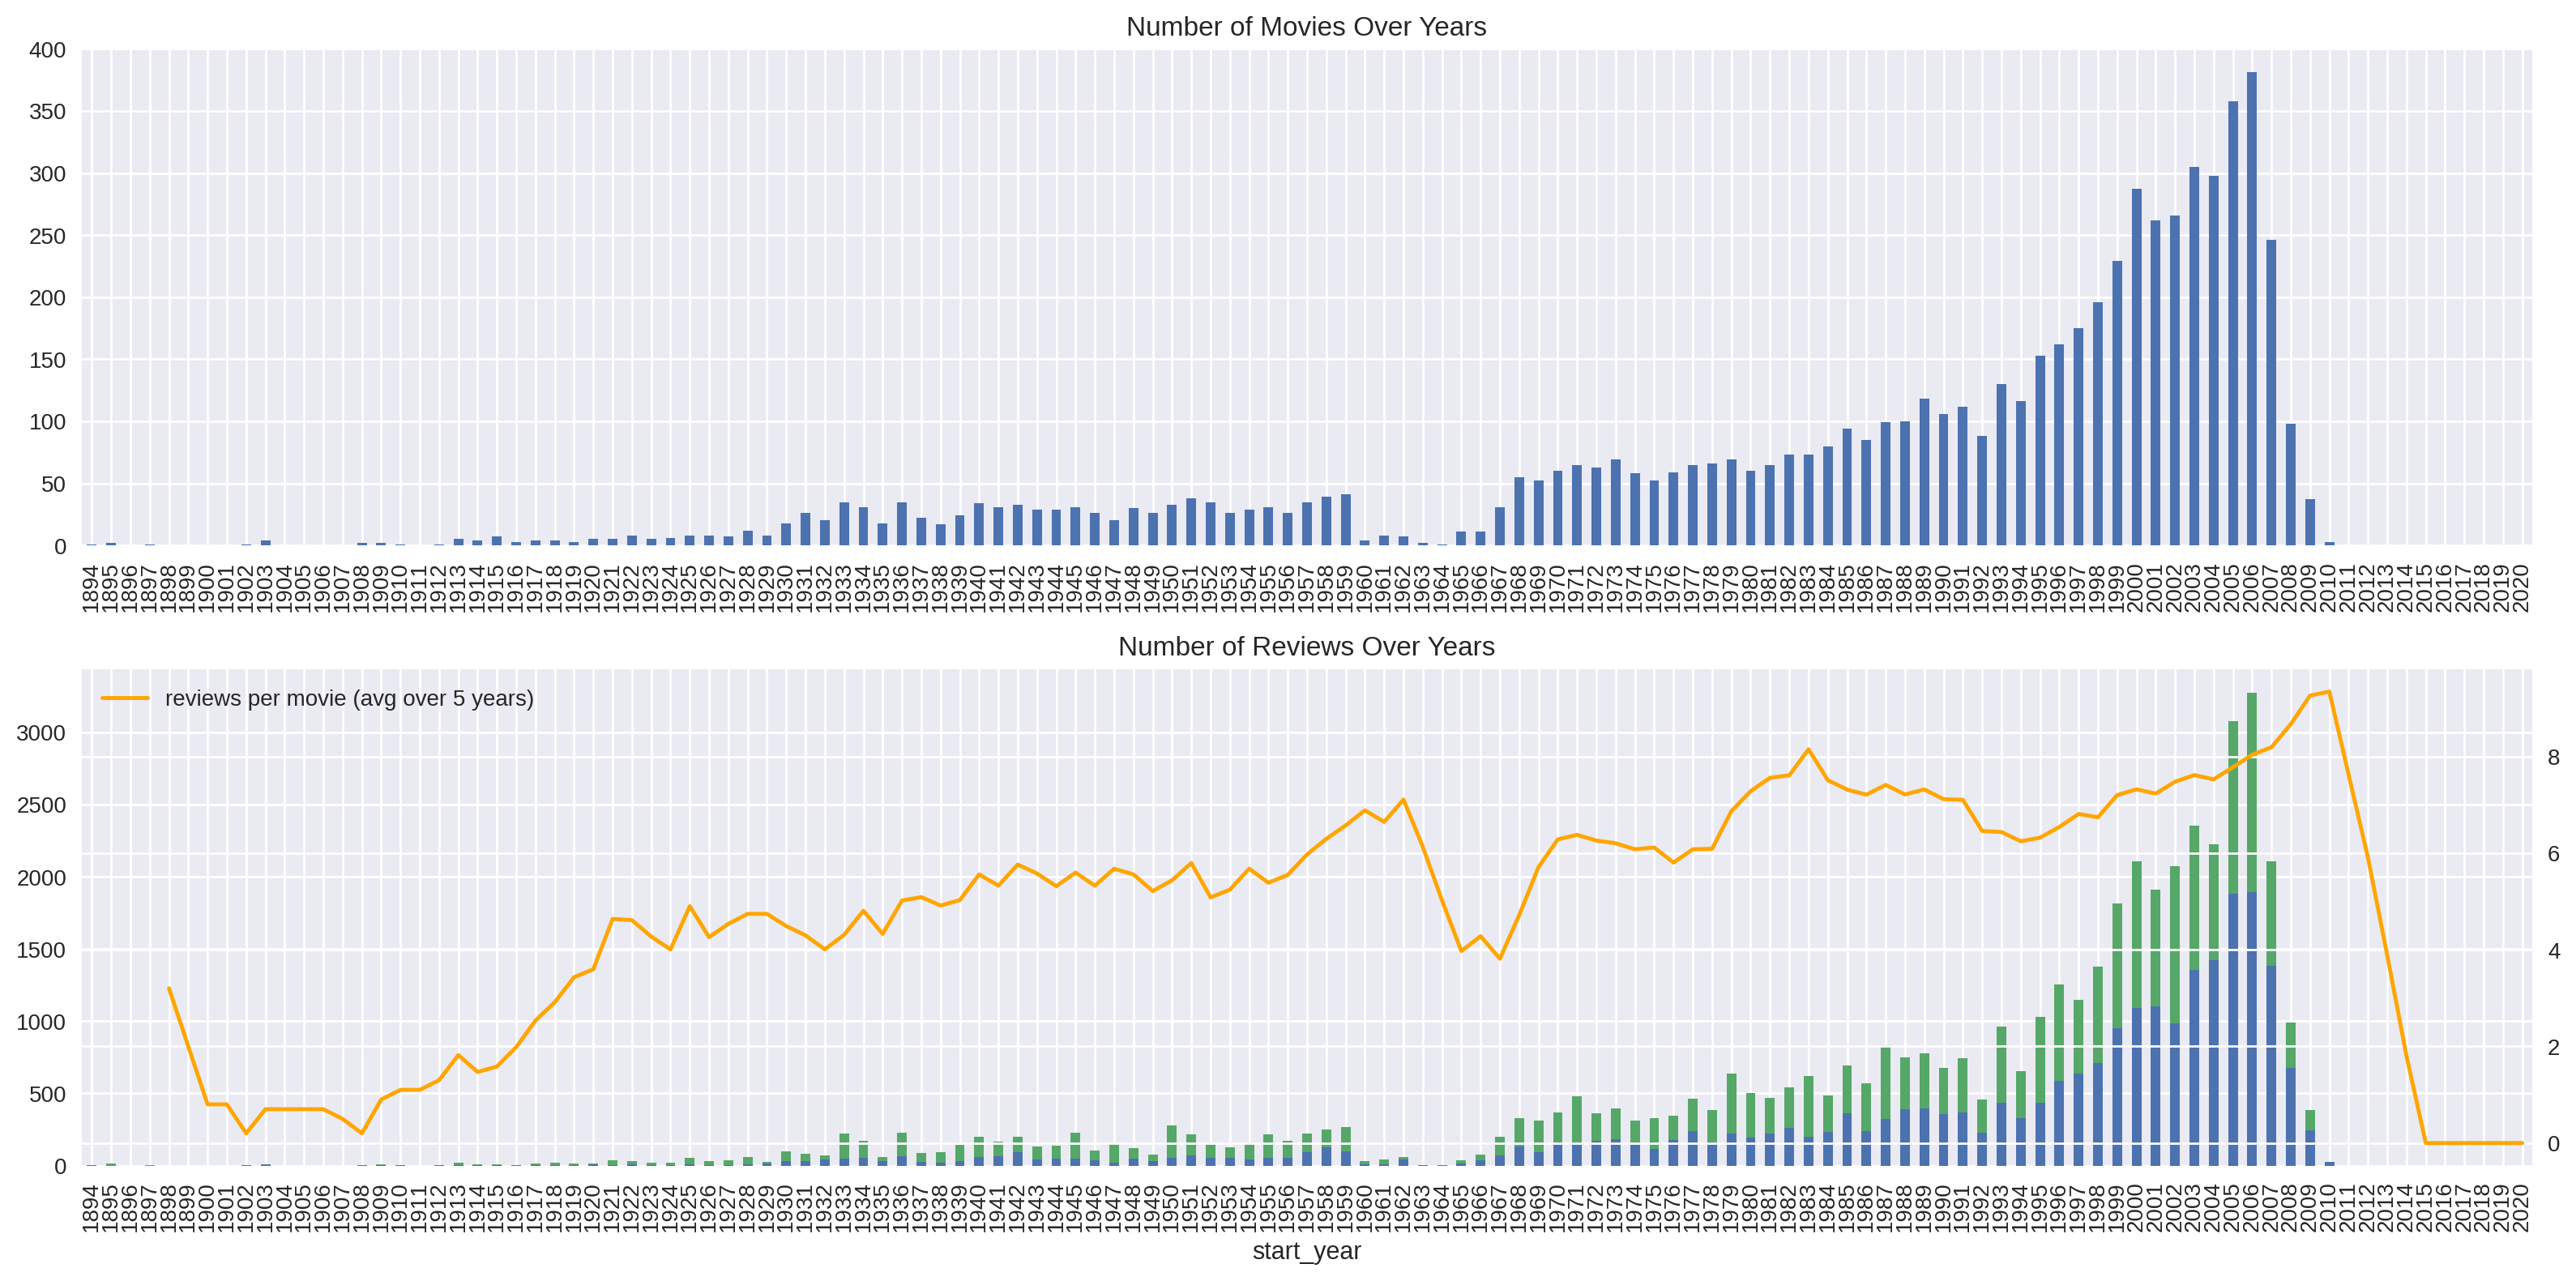

In [5]:
# Check the number of movies and reviews over years.

fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Note: The number of movies per year has increased over time, with a peak in 2006. The number of reviews per movie has trended upward.

Below we check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

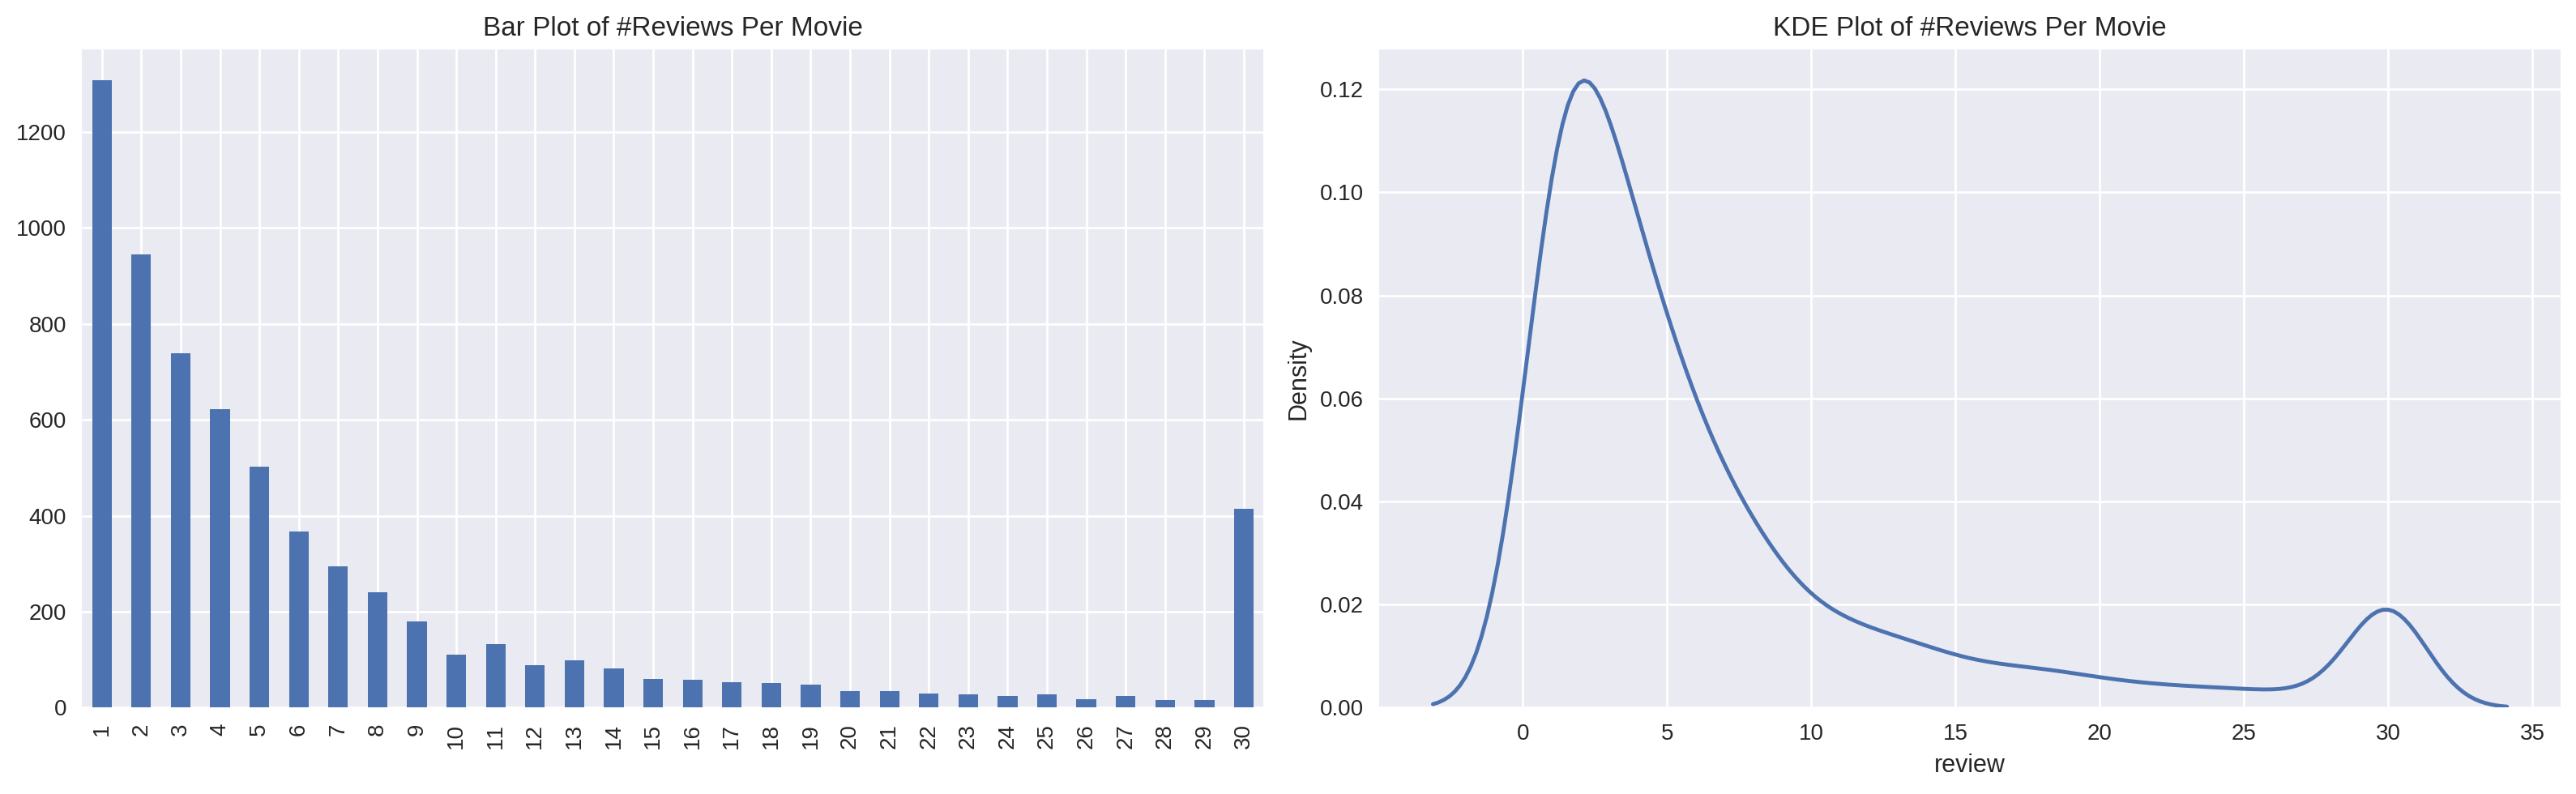

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [7]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

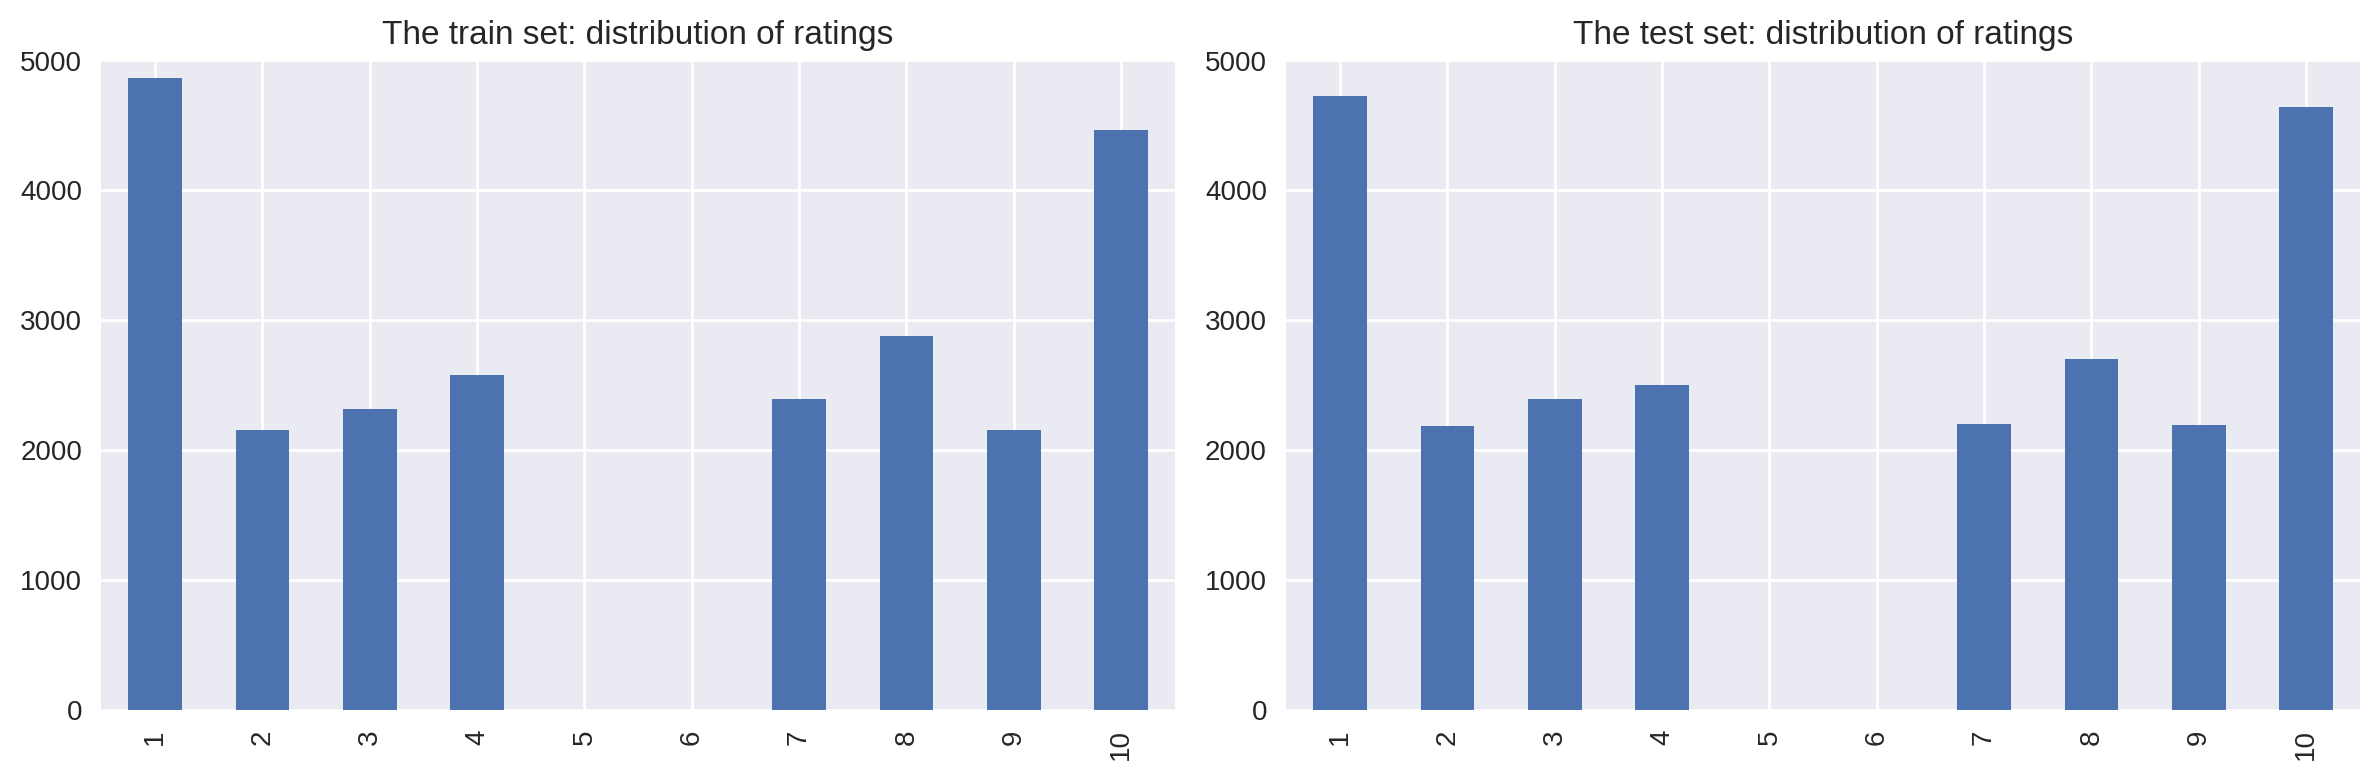

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


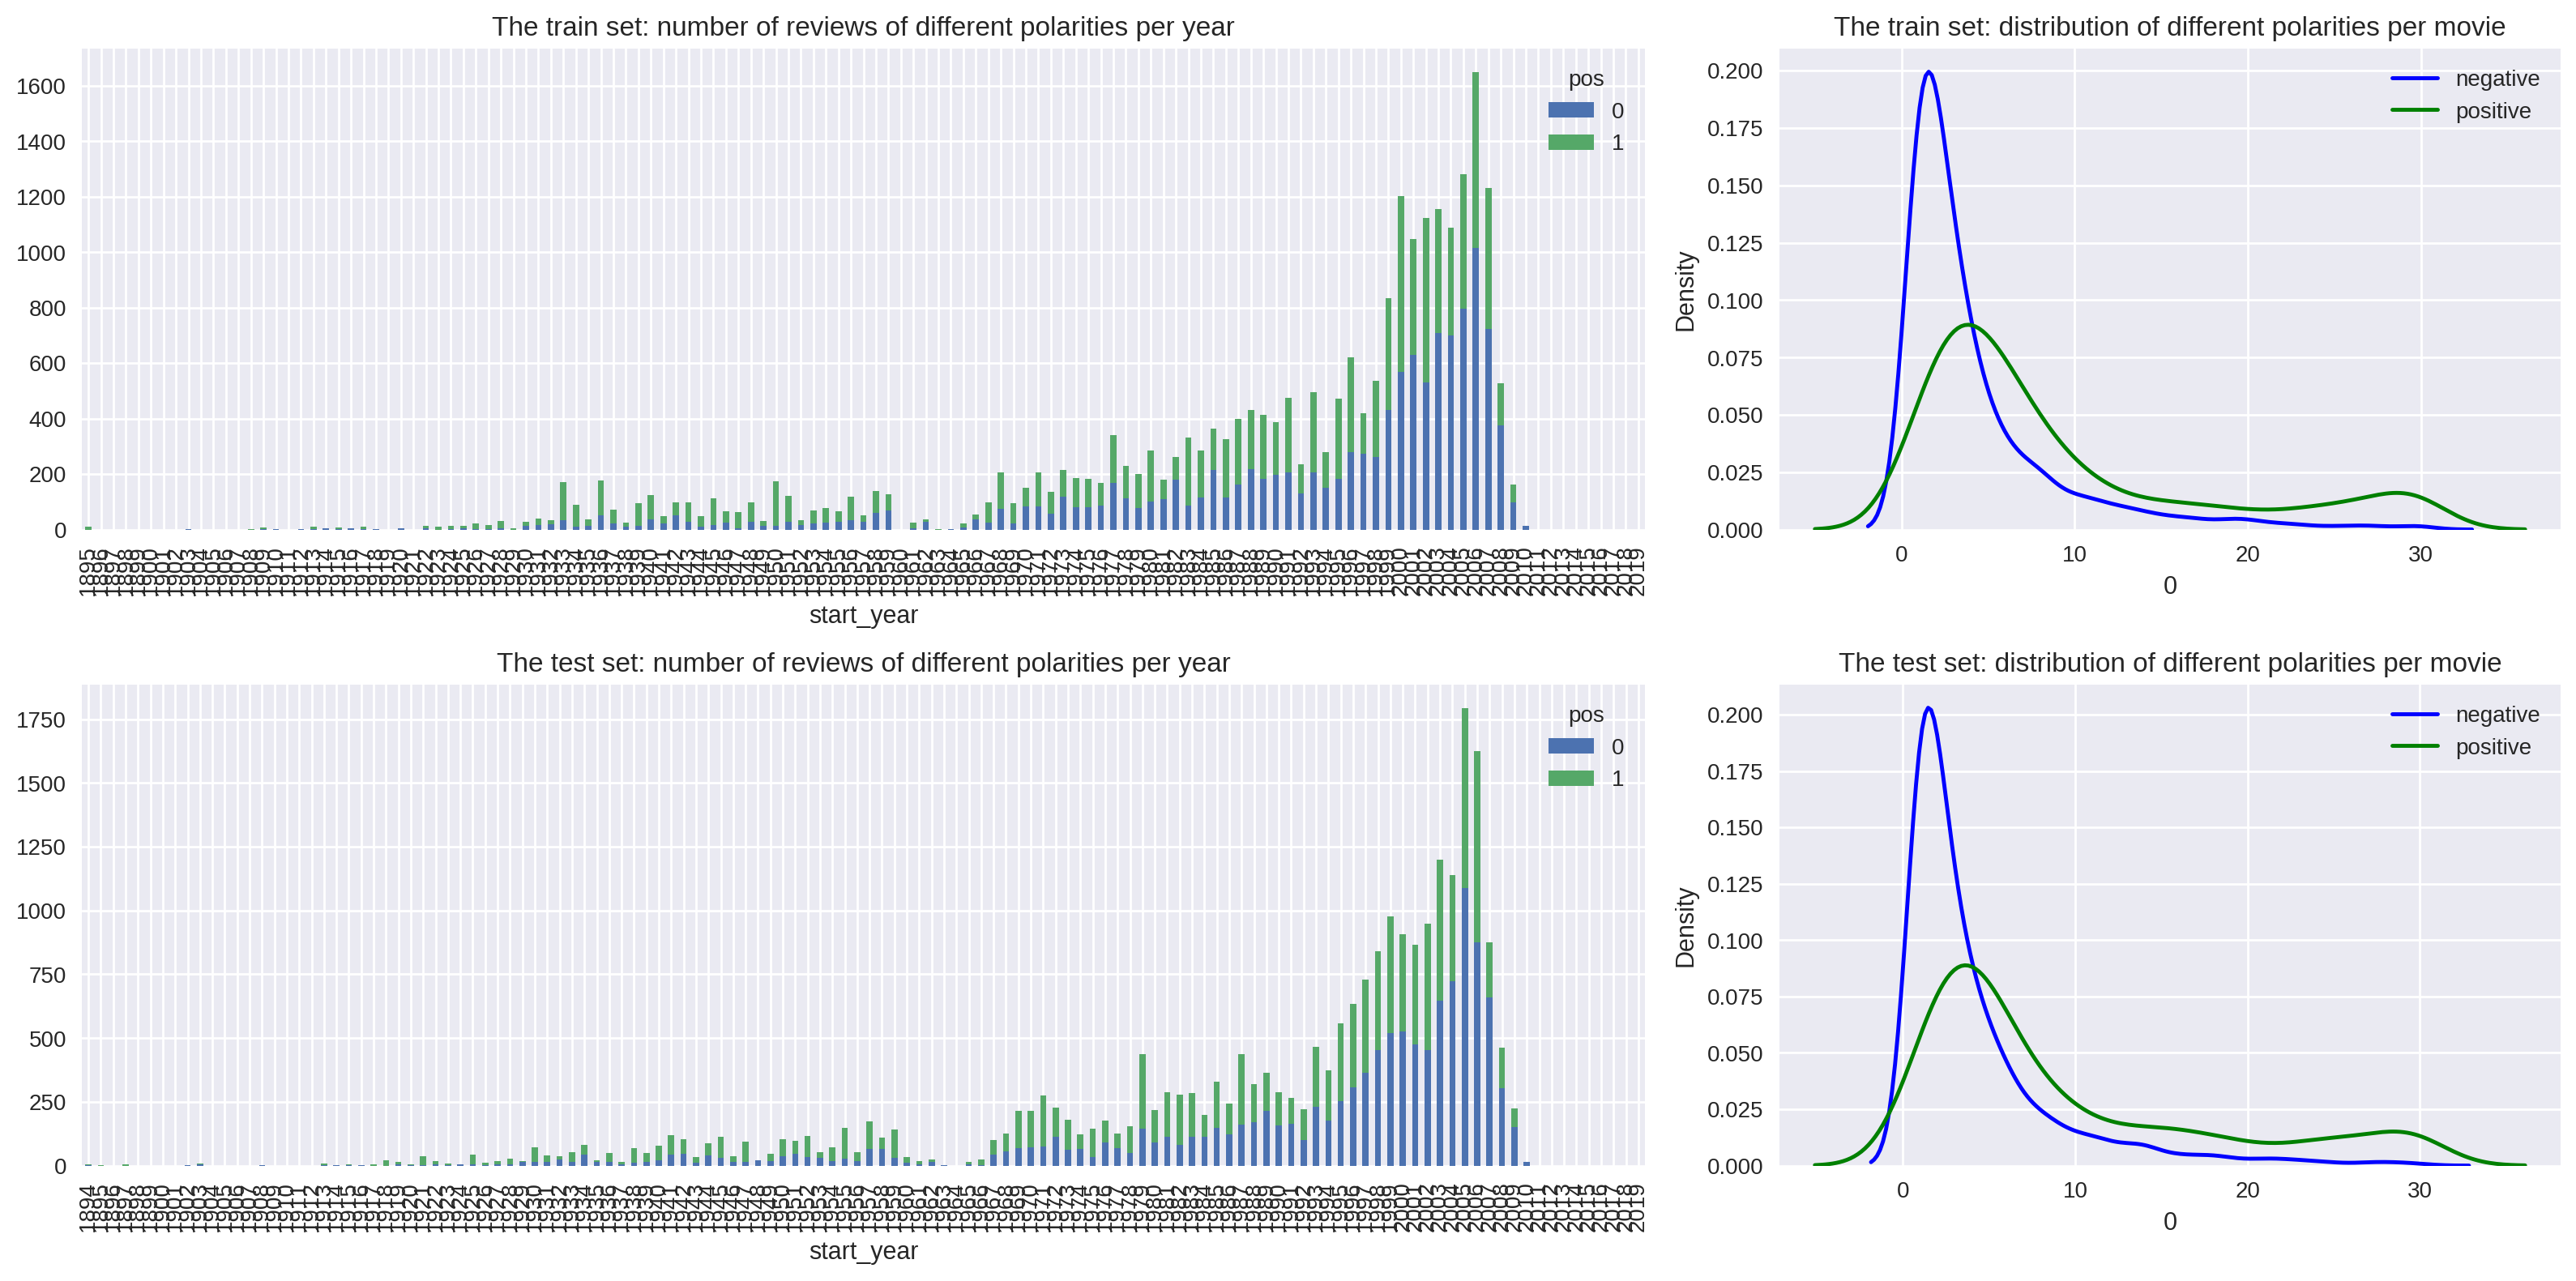

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project. This function streamlines evaluation for the models used.

In [10]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):

    """Defines a function evaluate_model that takes a model and datasets 
    for training and testing as input, evaluates the model's performance, and visualizes 
    various metrics. 
    
    F1 scores calculated for different thresholds, ROC curves and AUC, 
    precision-recall curves and average precision scores (APS), and accuracy. 
    
    Function plots F1 scores, ROC curves, and precision-recall curves with 
    specific threshold markers for both training and test sets, 
    and prints a summary of the evaluation statistics. """    
    
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

Text preprocessing is an essential step in natural language processing (NLP) tasks. It begins by importing necessary libraries from the Natural Language Toolkit (NLTK) and downloading required datasets. We define a function normalize_review that normalizes a given text review through several steps:

- Lowercasing: Converts all characters in the review to lowercase to ensure uniformity.
- Removing Punctuation and Digits: Uses regular expressions to strip out non-alphabetic characters.
- Tokenization: Splits the text into individual words (tokens).
- Removing Stop Words: Filters out common English stop words (e.g., "the", "and") that do not contribute much meaning.
- Lemmatization: Converts words to their base form, ensuring consistency (e.g., "running" becomes "run").

This process cleans and standardizes the text data, making it more suitable for further analysis or modeling in NLP applications.

In [11]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Create stemmer, lemmatizer and define stopwords - note below are from the NTLK library
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def normalize_review(review):
    # Lowercases the text
    review = review.lower()
    
    # Removes punctuation and digits
    review = re.sub(r'[^a-zA-Z\s]', '', review)
    
    # Tokenizes the text
    tokens = word_tokenize(review)
    
    # Removes stop words
    tokens = [word for word in tokens if word not in stop_words]
    
    # Stem or lemmatize tokens
    # tokens = [stemmer.stem(word) for word in tokens]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join tokens back into a single string
    normalized_review = ' '.join(tokens)
    
    return normalized_review

# Apply the normalization to the 'review' column

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
df_reviews['review_norm'] = df_reviews['review'].progress_apply(normalize_review)

  0%|          | 0/47331 [00:00<?, ?it/s]

## Train / Test Split

The whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [13]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Development of Models for Text Classification

### Model 0 - Constant

Model 0 is a dummy classifier which serves as a baseline for a model that cannot discern between positive and negative reviews. Model 0 is as good as a random classifier.

In [14]:
from sklearn.dummy import DummyClassifier

In [15]:
# Initialize the DummyClassifier with strategy 'most_frequent'
model_0 = DummyClassifier(strategy='most_frequent')


In [16]:
# Train the DummyClassifier on the training data
model_0.fit(df_reviews_train['review_norm'], train_target)

DummyClassifier(strategy='most_frequent')

In [17]:
# Predict the target on the training and testing data
train_pred_dummy = model_0.predict(df_reviews_train['review_norm'])
test_pred_dummy = model_0.predict(df_reviews_test['review_norm'])

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


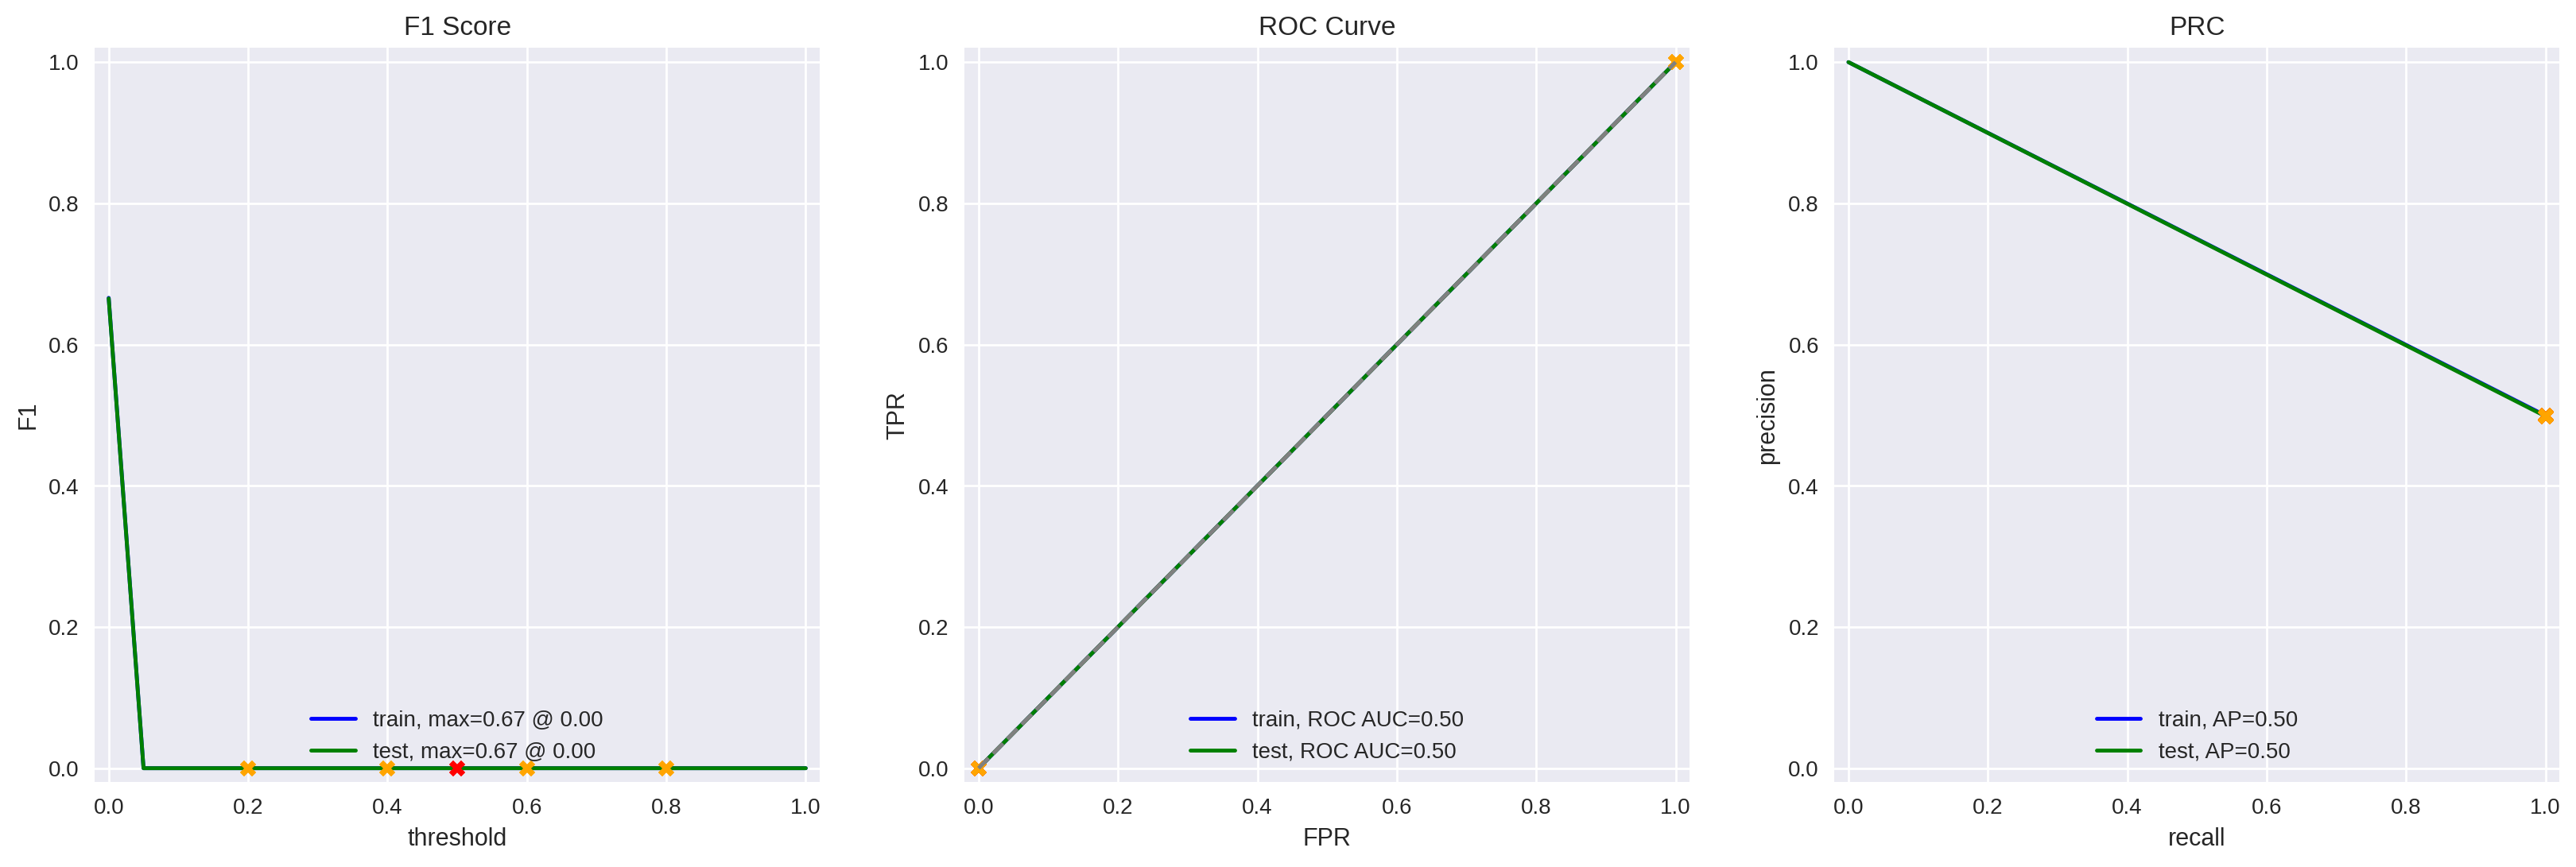

In [18]:
# Evaluate the DummyClassifier using the previously defined evaluate_model function
evaluate_model(model_0, df_reviews_train['review_norm'], train_target, df_reviews_test['review_norm'], test_target)

The accuracy of Model 0 is similar to a random prediction; it does not categorize well and cannot distinguish between positive and negative reviews

### Model 1 - NLTK, TF-IDF and LR

We will use NLTK TF-IDF and LR to train Model 1:

- NLTK (Natural Language Toolkit) -  a comprehensive suite of tools and resources for working with textual data. Text preprocessing, linguistic data analysis, and NLP applications.
- TF-IDF (Term Frequency - Inverse Document Frequency) - evaluates the importance of a word in a document relative to a collection of documents (corpus)
- LR (Logistic Regression) - LR will be used for classification in this model

In [19]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [20]:
# Vectorize data for model_1

vectorizer_1 = TfidfVectorizer(stop_words='english', max_features=5000)
train_features_1 = vectorizer_1.fit_transform(df_reviews_train['review_norm'])
test_features_1 = vectorizer_1.transform(df_reviews_test['review_norm'])

In [21]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx,review_norm
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335,pakage implies warren beatty goldie hawn pulli...
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336,hell get made presenting caper comedy misbegot...
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489,real story film seems like fly wall dramadocum...
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280,um serious film troubled teen singapore countr...
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281,im totally agree garryjohal singapore comment ...


In [22]:
# Train logistic regression for model_1

model_1 = LogisticRegression()
model_1.fit(train_features_1, train_target)

LogisticRegression()

          train  test
Accuracy   0.91  0.87
F1         0.91  0.87
APS        0.97  0.94
ROC AUC    0.97  0.95


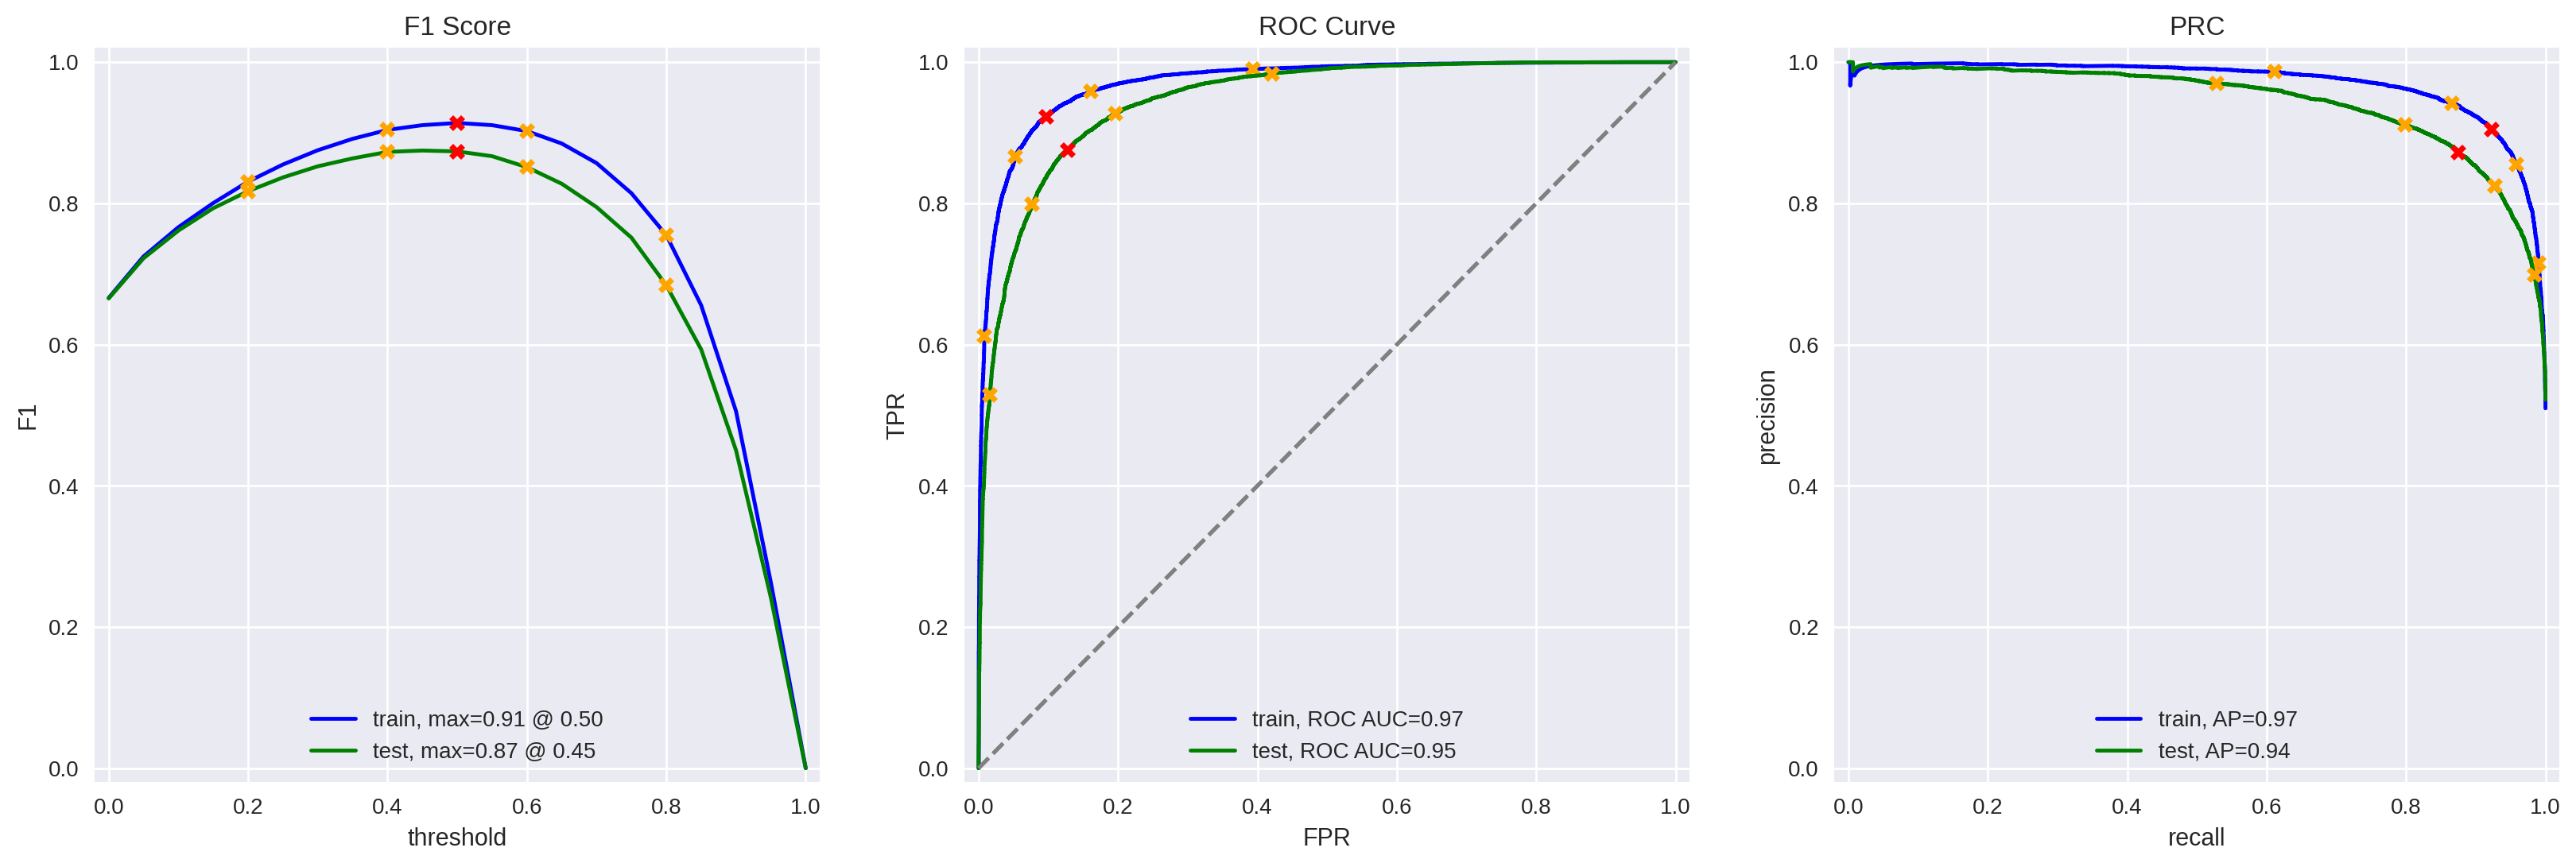

In [23]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Model 3 - spaCy, TF-IDF and LR

Model 3 utilizes spaCy, which is designed specifically for productionand provides fast and efficient tools for  NLP tasks

In [24]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [27]:
# Create spaCy function for preprocessing text

def text_preprocessing_3(text):
    doc = nlp(text)
    # Lemmatize tokens and remove stop words
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and not token.is_digit]
    return ' '.join(tokens)

In [28]:
# Apply the spaCy-based normalization

df_reviews['review_norm_spacy'] = df_reviews['review'].progress_apply(text_preprocessing_3)

  0%|          | 0/47331 [00:00<?, ?it/s]

In [29]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx,review_norm,review_norm_spacy
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335,pakage implies warren beatty goldie hawn pulli...,pakage imply Warren Beatty Goldie Hawn pull hu...
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336,hell get made presenting caper comedy misbegot...,hell present caper comedy misbegotten $ essent...
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489,real story film seems like fly wall dramadocum...,real story film like fly wall drama documentar...
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280,um serious film troubled teen singapore countr...,um film troubled teen Singapore country knowle...
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281,im totally agree garryjohal singapore comment ...,totally agree GarryJohal Singapore comment fil...


In [30]:
# Split the dataset into training and testing sets

df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

# Define the target variable for training and testing sets

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

In [31]:
# Create training and testing features for model_3

vectorizer_3 = TfidfVectorizer(stop_words='english', max_features=5000)
train_features_3 = vectorizer_3.fit_transform(df_reviews_train['review_norm_spacy'])
test_features_3 = vectorizer_3.transform(df_reviews_test['review_norm_spacy'])

In [32]:
# Initialize and train the Logistic Regression model

model_3 = LogisticRegression()
model_3.fit(train_features_3, train_target)

LogisticRegression()

          train  test
Accuracy   0.91  0.87
F1         0.91  0.87
APS        0.97  0.94
ROC AUC    0.97  0.94


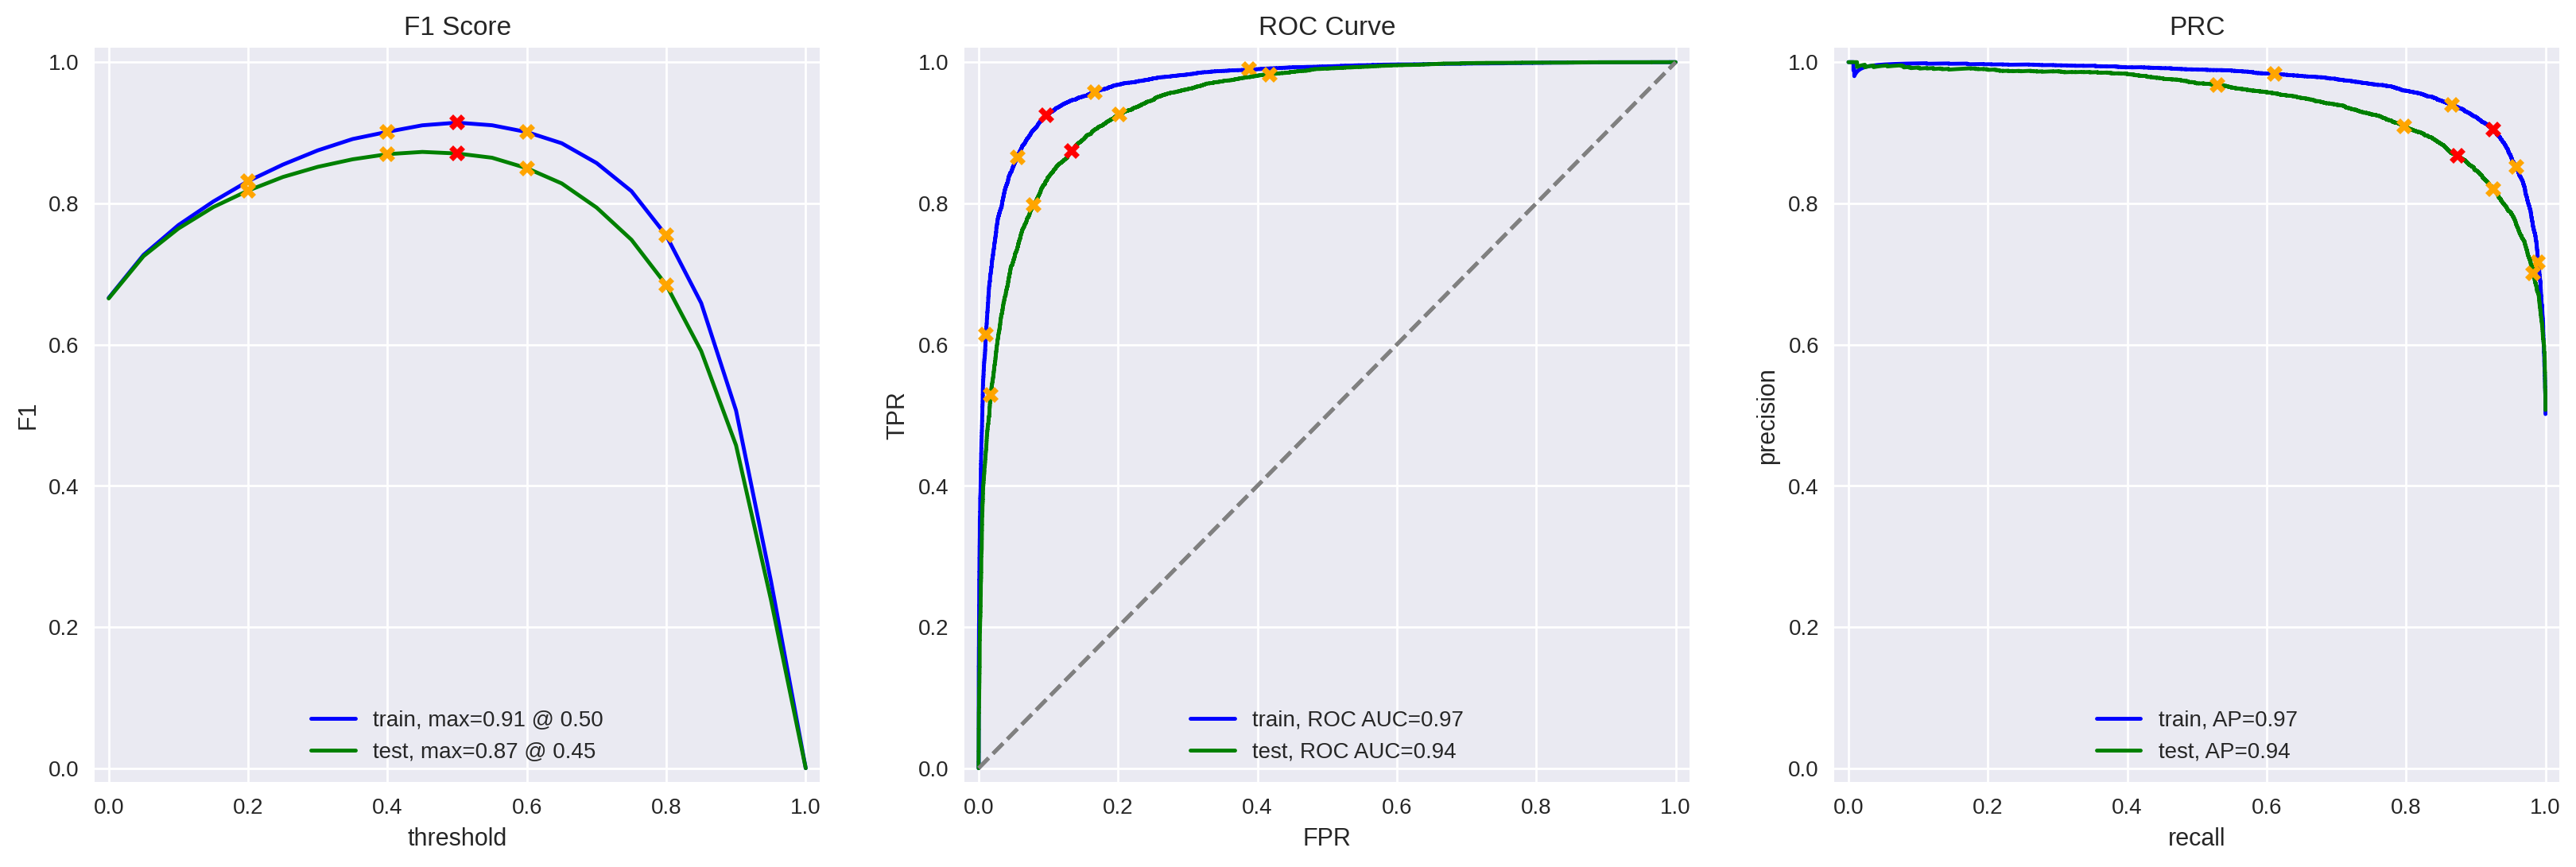

In [33]:
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

### Model 4 - spaCy, TF-IDF and LGBMClassifier

Model 4 utilizes spaCy but adds in the LGBM Classifier which adds in gradient boosting capabilities to the model, increasing speed and accuracy in many cases.

In [34]:
import spacy
from lightgbm import LGBMClassifier

In [35]:
# Load npl as spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [36]:
def text_preprocessing_4(text):
    doc = nlp(text)
    # Lemmatize tokens and remove stop words, punctuation, and digits
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and not token.is_digit]
    return ' '.join(tokens)

In [37]:
# Apply the spaCy-based normalization to the 'review' column

df_reviews['review_norm_spacy'] = df_reviews['review'].progress_apply(text_preprocessing_4)

  0%|          | 0/47331 [00:00<?, ?it/s]

In [38]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx,review_norm,review_norm_spacy
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335,pakage implies warren beatty goldie hawn pulli...,pakage imply Warren Beatty Goldie Hawn pull hu...
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336,hell get made presenting caper comedy misbegot...,hell present caper comedy misbegotten $ essent...
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489,real story film seems like fly wall dramadocum...,real story film like fly wall drama documentar...
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280,um serious film troubled teen singapore countr...,um film troubled teen Singapore country knowle...
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281,im totally agree garryjohal singapore comment ...,totally agree GarryJohal Singapore comment fil...


In [39]:
# Split the dataset once more into training and testing sets

df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

In [40]:
# Define the target variable for training and testing sets

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

In [41]:
# Vectorize the text data using TF-IDF

vectorizer_4 = TfidfVectorizer(stop_words='english', max_features=5000)
train_features_4 = vectorizer_4.fit_transform(df_reviews_train['review_norm_spacy'])
test_features_4 = vectorizer_4.transform(df_reviews_test['review_norm_spacy'])

In [42]:
# Initialize and train the LGBMClassifier model

model_4 = LGBMClassifier()
model_4.fit(train_features_4, train_target)

LGBMClassifier()

          train  test
Accuracy   0.91  0.85
F1         0.91  0.85
APS        0.97  0.93
ROC AUC    0.97  0.93


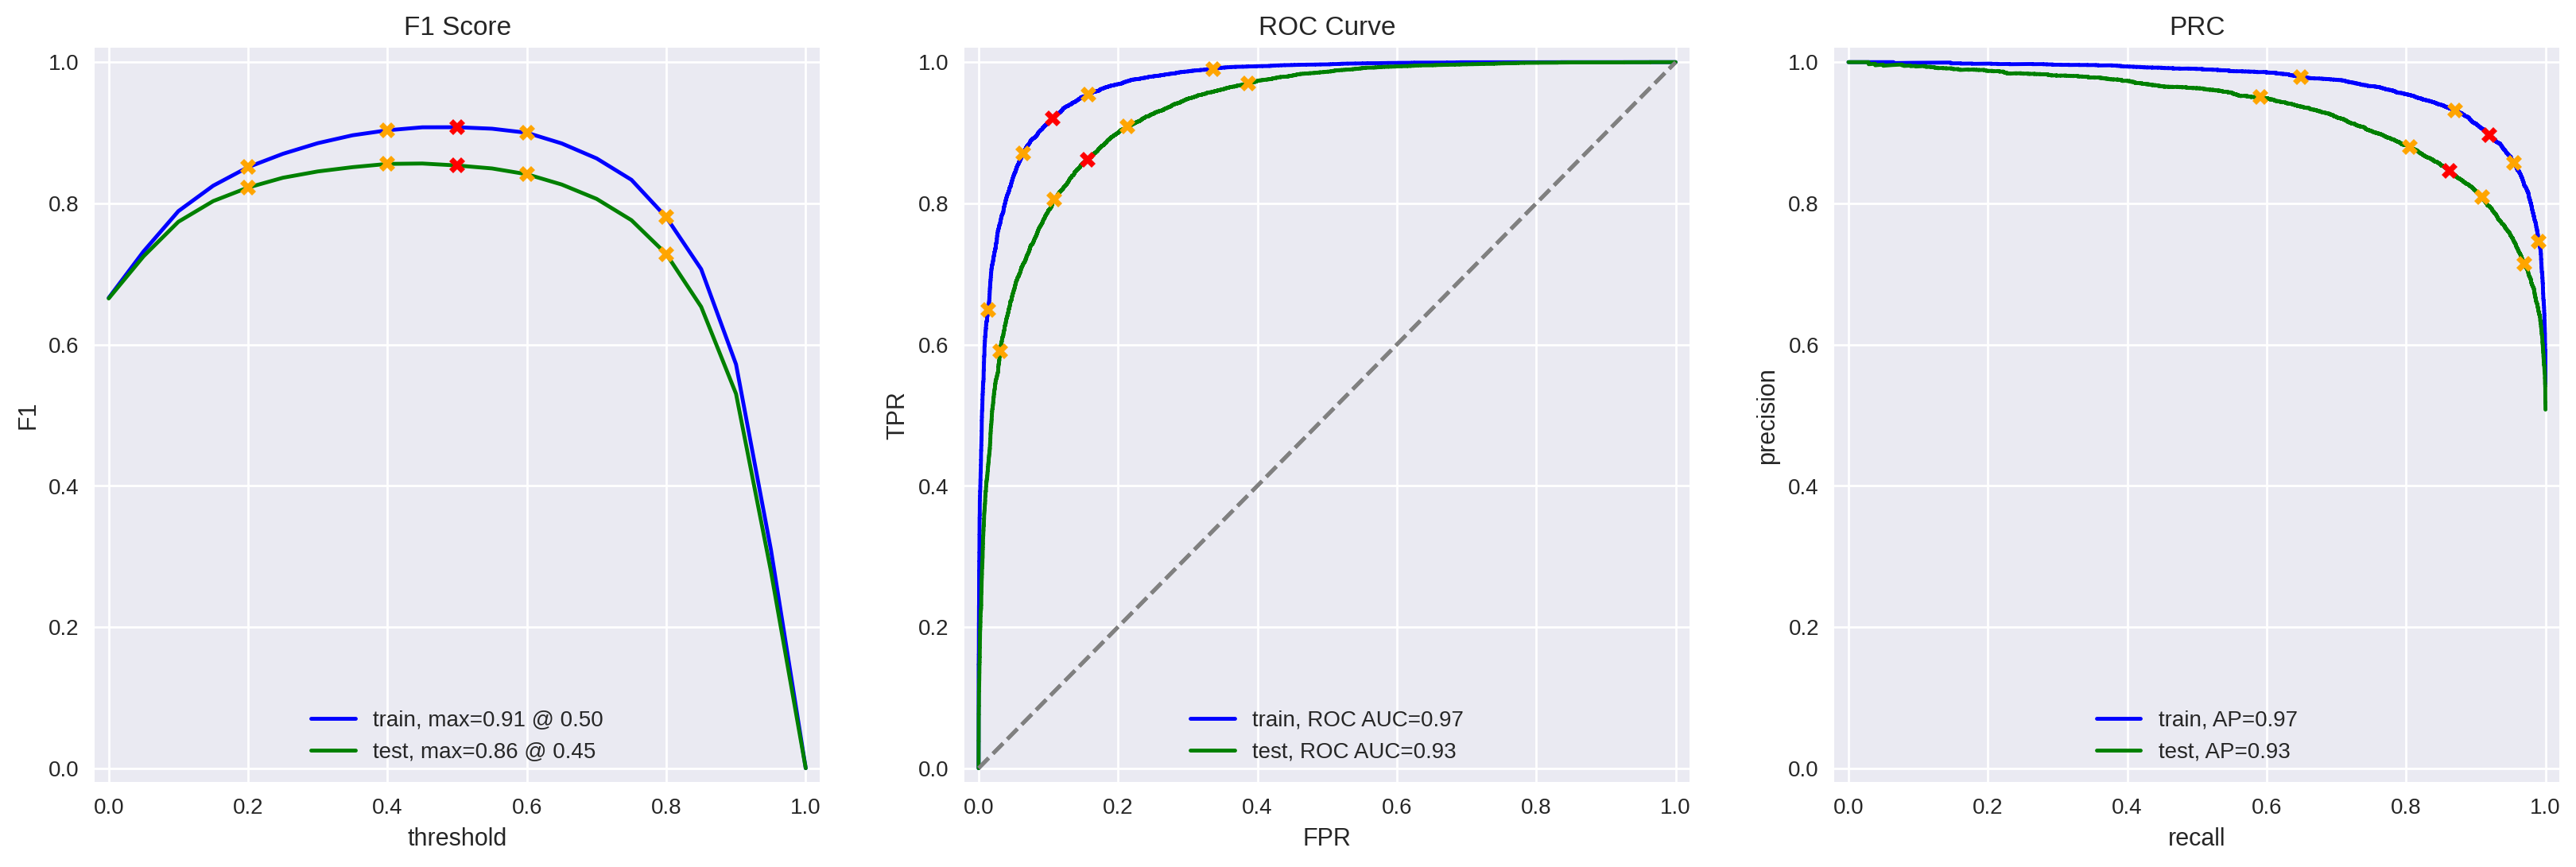

In [43]:
# Evaluate the model using the train and test set

evaluate_model(model_4, train_features_4, train_target, test_features_4, test_target)

General Note: We have successfully achieved an F1 > 0.85 in Models 1, 3, and 4

Note Model 2 (BERT) has been excluded from the analysis per project instructions.

## My Reviews

In [44]:
# These reviews are new reviews used as tests for the models

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].progress_apply(normalize_review)

  0%|          | 0/8 [00:00<?, ?it/s]

In [45]:
my_reviews.head()

,review,review_norm
0,"I did not simply like it, not my kind of movie.",simply like kind movie
1,"Well, I was bored and felt asleep in the middl...",well bored felt asleep middle movie
2,I was really fascinated with the movie,really fascinated movie
3,Even the actors looked really old and disinter...,even actor looked really old disinterested got...
4,I didn't expect the reboot to be so good! Writ...,didnt expect reboot good writer really cared s...


### Testing new reviews on "Model 1 - NLTK, TF-IDF and LR"

In [46]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.17:  simply like kind movie
0.07:  well bored felt asleep middle movie
0.60:  really fascinated movie
0.12:  even actor looked really old disinterested got paid movie soulless cash grab
0.16:  didnt expect reboot good writer really cared source material
0.42:  movie upside downside feel like overall decent flick could see going see
0.04:  rotten attempt comedy single joke land everyone act annoying loud even kid wont like
0.96:  launching netflix brave move really appreciate able binge episode episode exciting intelligent new d


### Testing new reviews on "Model 3 - spaCy, TF-IDF and LR"

In [47]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.20:  simply like kind movie
0.09:  well bored felt asleep middle movie
0.45:  really fascinated movie
0.10:  even actor looked really old disinterested got paid movie soulless cash grab
0.16:  didnt expect reboot good writer really cared source material
0.41:  movie upside downside feel like overall decent flick could see going see
0.03:  rotten attempt comedy single joke land everyone act annoying loud even kid wont like
0.95:  launching netflix brave move really appreciate able binge episode episode exciting intelligent new d


### Testing new reviews on Model 4 - spaCy, TF-IDF and LGBMClassifier

In [48]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_4.predict_proba(vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.59:  simply like kind movie
0.34:  well bored felt asleep middle movie
0.64:  really fascinated movie
0.40:  even actor looked really old disinterested got paid movie soulless cash grab
0.61:  didnt expect reboot good writer really cared source material
0.62:  movie upside downside feel like overall decent flick could see going see
0.27:  rotten attempt comedy single joke land everyone act annoying loud even kid wont like
0.79:  launching netflix brave move really appreciate able binge episode episode exciting intelligent new d


## Conclusions

To simplify the excercise, BERT modeling (Model 2) was excluded from the analysis. BERT modeling can be used in future analyses to test and improve model accuracy.

- Models 1 and 3 have more meaningful difference in the the scores given to the predictions - ie sentiments that are clearly positive show a score closer to 1 and those that are negative show a score closer to 0, whereas Model 4 does not. This aligns with the lower accuracy scores of Model 4 on the test set.
- LR is noted to be better at capturing linear or binary relationships, and sentiment analysis for movies aligns with this relationship
- Further work on this data set could include fine tuning the LGBM model and adjusting the parameters.